<a href="https://colab.research.google.com/github/vyankateshgithubber/speech-analyer/blob/Speech_to_text/TOGTHER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From here onwards i would like to do the tensorflow model.


In [ ]:
!pip install flask-ngrok
! pip install SpeechRecognition
!apt install libasound2-dev portaudio19-dev
! pip install PyAudio
!pip uninstall ffmpeg 
!pip uninstall ffmpeg-python
! pip install SpeechRecognition
! pip install ffmpeg-python
!pip install librosa

     |████████████████████████████████| 32.8MB 114kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libasound2-dev is already the newest version (1.1.3-5ubuntu0.5).
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 31 not upgraded.
Need to get 184 kB of archives.
After this operation, 891 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudiocpp0 amd64 19.6.0-1 [15.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 portaudio19-dev amd64 19.6.0-1 [104 kB]
Fetched 184 kB in 2s (102 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Speech_Analyzer/Datasets/train.txt",sep=';')
train_df.columns = ["Sentance","Emotion"]

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences



def tokenize(tweets):
    stop_words = stopwords.words("english")
    tokenized_tweets = []
    for tweet in tweets:
        # split all words in the tweet
        words = tweet.split(" ")
        tokenized_string = ""
        for word in words:
            # remove @handles -> useless -> no information
            if word[0] != '@' and word not in stop_words:
                # if a hashtag, remove # -> adds no new information
                if word[0] == "#":
                    word = word[1:]
                #word = ps.stem(word) # stemming line
                tokenized_string += word + " "
            
        tokenized_tweets.append(tokenized_string)
    return tokenized_tweets


def encod_tweets(tweets):
    tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split=" ", lower=True)
    tokenizer.fit_on_texts(tweets)
    return tokenizer, tokenizer.texts_to_sequences(tweets)

tokenized_tweets = tokenize(train_df['Sentance'])
tokenizer, encoded_tweets = encod_tweets(tokenized_tweets)

import random
def tok(data,emotion):
  index = data.index
  index = random.choice(index[data['Emotion']==emotion])
  s = data['Sentance'][index]
  to = tokenizer.texts_to_sequences([s])
  to = pad_sequences(to, maxlen= 20, padding='post')
  to = np.array(to,dtype="float32")
  data.drop(index=index)
  return to,data


In [ ]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")#32
        sample_rate=sound_file.samplerate
        print("MFCC")
      
        #if chroma:
         #   stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=16000, n_mfcc=40).T, axis=0)
            print("MFCC")
            result=np.hstack((result, mfccs))
        #if chroma:
        #    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=16000).T,axis=0)
        #    result=np.hstack((result, chroma))
        #if mel:
         #   mel=np.mean(librosa.feature.melspectrogram(X, sr=16000).T,axis=0)
         #   result=np.hstack((result, mel))
    return result

In [ ]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}        
# 'disgust':'anger','calm':'love','angry':'anger','neutral':'love'
#DataFlair - Emotions to observe
observed_emotions=['happy','disgust','calm','angry','neutral','surprised','fearful','sad']

In [ ]:
#DataFlair - Load the data and extract features for each sound file
def load_data(train_df,test_size):
    x,y=[],[]    
    x = np.empty((1,60))
    count_sad=0
    count_happy=0
    map = {'happy':'joy','surprised':'surprise','disgust':' ','calm':'surprise','angry':'anger','neutral':' ','fearful':'fear','sad':'sadness'}
    for file in glob.glob("/content/drive/MyDrive/Speech_Analyzer/Datasets/ravdess/RAVDESS/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feeling = map[emotion]
        feature=extract_feature(file, mfcc=True, chroma=False, mel=False)
        feature = feature.astype('float32')
        if(feeling!=' '):
          tokenized, train_df = tok(train_df,feeling)
        else:
          tokenized = np.zeros((1,20))
        tokenized = np.reshape(tokenized,(1,-1))
        feature = np.reshape(feature,(1,-1))
       # print(tokenized,feature)
        out = np.hstack((feature,tokenized))
        if emotion=='happy':
          count_happy+=1
        if emotion=='sad':
          count_sad+=1
        if count_sad<=count_happy and emotion=='sad':
          x = np.vstack([x, out])
          y.append(observed_emotions.index(emotion))
        elif emotion !='sad':
          x = np.vstack([x, out])
          y.append(observed_emotions.index(emotion))
    count_sad=0
    count_happy=0
    for file in glob.glob("/content/drive/MyDrive/Speech_Analyzer/Datasets/TESS/*.wav"):
        file_name=os.path.basename(file)
        emotion=file_name.split("_")[2][:-4]
        if emotion not in observed_emotions:
            continue
        feeling = map[emotion]
        feature=extract_feature(file, mfcc=True, chroma=False, mel=False)
        feature = feature.astype('float32')
        if(feeling!=' '):
          tokenized, train_df = tok(train_df,feeling)
        else:
          tokenized = np.zeros((1,20))
        tokenized = np.reshape(tokenized,(1,-1))
        feature = np.reshape(feature,(1,-1))
       # print(tokenized,feature)
        out = np.hstack((feature,tokenized))
        if emotion=='happy':
          count_happy+=1
        if emotion=='sad':
          count_sad+=1
        if count_sad<=count_happy and emotion=='sad':
          x = np.vstack([x, out])
          y.append(observed_emotions.index(emotion))
        elif emotion !='sad':
          x = np.vstack([x, out])
          y.append(observed_emotions.index(emotion))
    x = np.delete(x,0,0)
    return train_test_split(x, np.array(y), test_size=test_size, random_state=9)

In [ ]:
#DataFlair - Split the dataset
x_train,x_test,y_train,y_test=load_data(train_df,test_size=0.20)

Streaming output truncated to the last 5000 lines.
   2.0725594e+00 -3.1491849e+00 -1.7808912e+00  7.4545326e+00
  -2.8705060e-01  5.3964919e-01  5.3706374e+00  1.5751946e+00
   1.8952237e-01  6.1476791e-01  8.8148087e-01 -9.0399735e-02
   3.8883643e+00 -8.0031323e-01 -1.6256263e+00 -1.6877434e+00
  -4.0760450e+00 -2.4842823e+00 -3.3388915e+00 -2.0832422e+00
  -4.4786677e+00 -4.8662868e+00 -1.9428288e+00 -4.0565853e+00]]
[[4.000e+00 6.100e+01 1.150e+03 4.100e+01 8.490e+02 2.000e+00 2.870e+02
  2.825e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]] [[-5.15181458e+02  6.65804520e+01  3.59842224e+01  1.40077705e+01
   1.64951134e+01  1.93503380e+01  9.46255398e+00  5.11667871e+00
  -1.35238695e+01 -1.21409871e-01 -7.50649071e+00 -4.74156952e+00
   3.89663339e-01 -1.25445471e+01 -4.22204018e+00  3.92400074e+00
   3.89253807e+00 -2.33272696e+00 -7.10911655e+00  6.10361910e+00
  -5.87928152e+00  2.81488991e+00  2.

In [ ]:
x_train.shape,y_train.shape

((2234, 60), (2234,))

In [ ]:
x_traincnn=np.expand_dims(x_train,axis=2)
x_testcnn=np.expand_dims(x_test,axis=2)

In [ ]:
x_traincnn.shape, x_testcnn.shape

((2234, 60, 1), (559, 60, 1))

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import keras
from matplotlib.pyplot import specgram
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense , Embedding
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.layers import Input,Flatten,Dropout,Activation
from keras.layers import Conv1D,MaxPooling1D,AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix,classification_report


model=Sequential()
model.add(Conv1D(256,5,padding='same',input_shape=(60,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))#0.1/0.2
model.add(Conv1D(128,5,padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128,5,padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128,5,padding='same'))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt=keras.optimizers.RMSprop(lr=0.00001,decay=1e-6)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60, 256)           1536      
_________________________________________________________________
activation (Activation)      (None, 60, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 128)           163968    
_________________________________________________________________
activation_1 (Activation)    (None, 60, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7, 128)            8

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn,y_train,batch_size=16,epochs=250,validation_data=(x_testcnn,y_test))

Epoch 1/250
140/140 [==============================] - 7s 44ms/step - loss: 28.8088 - accuracy: 0.1601 - val_loss: 9.7343 - val_accuracy: 0.3649
Epoch 2/250
140/140 [==============================] - 6s 42ms/step - loss: 10.5723 - accuracy: 0.3401 - val_loss: 7.7481 - val_accuracy: 0.3631
Epoch 3/250
140/140 [==============================] - 6s 42ms/step - loss: 8.3452 - accuracy: 0.3494 - val_loss: 7.3879 - val_accuracy: 0.3721
Epoch 4/250
140/140 [==============================] - 6s 42ms/step - loss: 7.9273 - accuracy: 0.3269 - val_loss: 6.6716 - val_accuracy: 0.3757
Epoch 5/250
140/140 [==============================] - 6s 42ms/step - loss: 7.1743 - accuracy: 0.3439 - val_loss: 6.9186 - val_accuracy: 0.3309
Epoch 6/250
140/140 [==============================] - 6s 42ms/step - loss: 7.1378 - accuracy: 0.3654 - val_loss: 5.9142 - val_accuracy: 0.3989
Epoch 7/250
140/140 [==============================] - 6s 42ms/step - loss: 6.9067 - accuracy: 0.3717 - val_loss: 6.5164 - val_accurac

In [ ]:
#model = keras.models.load_model('/content/drive/MyDrive/my_model')

In [ ]:
#https://heartbeat.fritz.ai/working-with-audio-signals-in-python-6c2bd63b2daf
score = model.evaluate(x_testcnn, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
  
y_pred = model.predict(x_testcnn)

Test loss: 1.8754173517227173 / Test accuracy: 0.6940966248512268


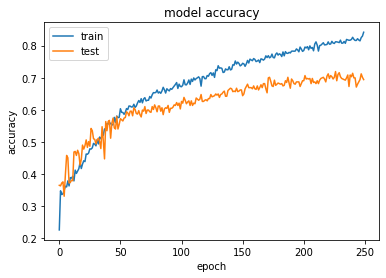

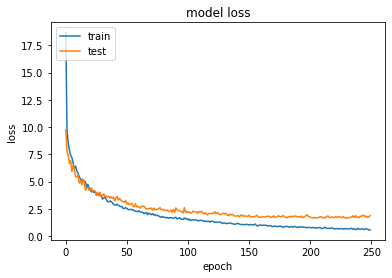

In [ ]:
# summarize history for accuracy
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#model.save('/content/drive/MyDrive/my_model')

In [ ]:
import speech_recognition as sr
import pyaudio
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
from scipy.io.wavfile import write
import io
import ffmpeg
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""
def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))
  write('test.wav', sr, audio)
  return audio, sr

In [ ]:
audio , sr = get_audio()
#audio, sr=librosa.load('test.wav',sr=16000)
#write('test.wav', 16000, audio)
print(sr,audio)
#commenting second layer drop out gave good predictions
# 
# i didnt really feel that embarrassed;sadness
# 
# i feel a bit rude writing to an elderly gentleman to ask for
# gifts because i feel a bit greedy but what is christmas about if not mild greed;anger

48000 [0 0 0 ... 0 0 0]


In [ ]:
def next_block(filepath,text):
  feature=extract_feature(filepath, mfcc=True, chroma=False, mel=False)
  print("Dds")
  feature=np.reshape(feature,(1,-1))
  #text = tokenize([text])
  to = tokenizer.texts_to_sequences([text])
  to = pad_sequences(to, maxlen= 20 , padding='post')
  to = np.array(to)  
  to = np.reshape(to,(1,-1))
  print(to,feature)
  feature1 = np.hstack((feature,to))
  feature1 = np.reshape(feature1,(1,60,1))
  a = model.predict(feature1)
  classes = np.argmax(a, axis = 1)
  print("Emotion : " ,classes," ",observed_emotions[classes[0]])


import time
import pyaudio
import speech_recognition as sr
filepath = '/content/OAF_came_ps.wav'
def callback(recognizer , audio):
    try:
        input_string=recognizer.recognize_google(audio,language="en-SG")
        #first run the next_block cell and then run this one 
        print(input_string)
        print("Calling")
        next_block(filepath=filepath,text=input_string) 
    except:
        print("Opps didn't catch")
r=sr.Recognizer()
m=sr.AudioFile(filepath)
with m as source:
        r.dynamic_energy_threshold=True
        r.adjust_for_ambient_noise(source,duration=1)
        time.sleep(0.5)
stop_listening=r.listen_in_background(m,callback)
for _ in range(8):time.sleep(0.1) 
stop_listening()
for i in range(5):time.sleep(0.1)

say the word came
Calling
MFCC
MFCC
Dds
[[ 40 633 250   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]] [[-4.19660797e+02  7.60371552e+01  1.64447498e+01  8.93947315e+00
   8.64457607e+00  9.61331081e+00 -1.23820715e+01  2.99569559e+00
  -3.45741034e+00 -5.77696419e+00  1.81221366e+00 -9.06125546e+00
  -1.12520227e+01 -3.51693630e+00 -9.68292046e+00 -4.11655617e+00
  -7.71625817e-01 -5.07446766e+00 -5.19584084e+00 -6.48605049e-01
  -3.00789356e+00 -1.55211079e+00  2.81785727e-01 -1.54087591e+00
   4.20579672e+00 -9.19178426e-01  2.65593338e+00  1.65931678e+00
   6.08527184e-01  2.61035109e+00  8.64984214e-01  7.65208006e-01
   7.88029134e-01  3.48496884e-01  5.95640779e-01  6.25537574e-01
  -5.16888559e-01 -1.47501457e+00  6.75770402e-01 -4.06940758e-01]]
Emotion :  [0]   happy
